# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

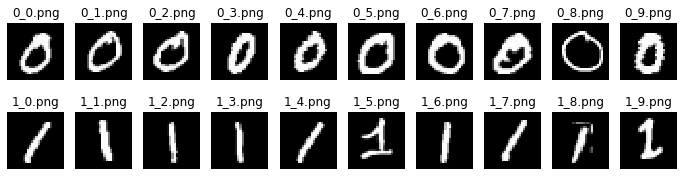

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)


### 1.2 Fourier descriptors
Add your implementation and discussion

### Invariances rotation, translation, scaling -- MS, CV, WJ

In [3]:
zeros_im[zeros_im>0] = 255
ones_im[ones_im>0] = 255

In [4]:
from skimage import feature
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import skimage.measure as measure

from skimage.transform import rotate, AffineTransform, warp
import random
import cv2
import math

In [5]:
# Helper functions
# Convert contour into complex signals
def convert_signal(contour):
#     contour -= contour.mean() # do we demean the data?
    output = np.zeros((np.array(contour).shape[0],1))
    output = contour[:,1] + 1j*contour[:,0] 
    return output

# Find outer contour and convert
def contour_fourier(images):
    contour_out = []
    for im in images:
        im = ndimage.binary_fill_holes(im)
        im[im>0] =255
        contours = measure.find_contours(im, 0)
        contour = sorted(contours, key=lambda x: len(x))[-1]
        contour_out.append(convert_signal(contour))
    return np.array(contour_out)



# Helper functions to increase dataset

def rotateImage(img):
    # Test with different rotations (or we should just keep one? or all of them?)
    # I have tried also with numpy e.g. np.rot90(img) but I got almost the same result
    # skimage: from skimage import measure, transform
    # a = transform.rotate(img, 90, resize=False, preserve_range=True).astype('uint8')
    
    r = random.randint(1, 3)
    r = 1 # for testing
    if (r == 1):
        a = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif (r == 2):
        a = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        a = cv2.rotate(img, cv2.ROTATE_180)
    return a #the invariance seems not working (?)
    
    

def translateImage(img):
    x = random.randint(-2, 2)
    y = random.randint(-2, 2)
    shift = AffineTransform(translation=(x, y))
    return warp(img, shift, mode="wrap")
    
def scaleImage(img): # TODO: I will check and try to fix it
    scale_img = np.pad(img, ((5,5),(5,5)), mode='constant',constant_values=0)
    resized = cv2.resize(scale_img, (img.shape[0],img.shape[1]))
    return resized

def dataAugmentation(img):
    '''
    Return [original_img, rot_clockwise, rot_anticlockwise, translated, scaled]
    '''
    imgs = [img]
    rot = rotateImage(img)
    imgs.append(rot)
    shifted = translateImage(img)
    imgs.append(shifted)
    scaled = scaleImage(img)
    imgs.append(scaled)
    return imgs

def affineTransform(img, rotation, scaling, translation):
    if rotation:
        img = rotateImage(img)
    if scaling:
        img = scaleImage(img)
    if translation:
        img = translateImage(img)
    return img


# Plot images with contours
def plotImagContour(axes, contourf_0, contourf_1, zeros_im, ones_im, zeros_names, ones_names):
    for ax0, ax1, contour0, contour1,im0, im1, nm0, nm1 in zip(axes[0], axes[1], contourf_0, contourf_1, zeros_im, ones_im, zeros_names, ones_names):
        ax0.imshow(im0)
        ax0.step(np.real(contour0), np.imag(contour0), linewidth=2, c='r')
        ax0.axis('off')
        ax0.set_title(nm0)

        ax1.imshow(im1)
        ax1.step(np.real(contour1), np.imag(contour1), linewidth=2, c='r')
        ax1.axis('off')
        ax1.set_title(nm1)

In [6]:
zeros_im[0].shape

(28, 28)

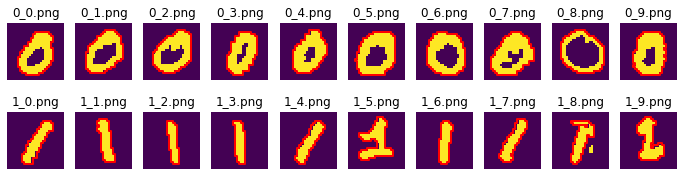

In [7]:
# Contour detection
contourf_0 = contour_fourier(zeros_im)
contourf_1 = contour_fourier(ones_im)

# Plots
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
plotImagContour(axes, contourf_0, contourf_1, zeros_im, ones_im, zeros_names, ones_names)


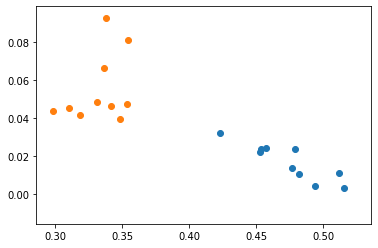

In [8]:
# original images
f1 = 1
f2 = 3
div = 0 # No division when set to -1
# N = 30 # number of pts in fft

FD_0 = np.zeros((10,2))
FD_1 = np.zeros((10,2))

for i in range(10):
    
    fft0 = np.fft.fft(contourf_0[i])#,n = N)
    fft1 = np.fft.fft(contourf_1[i])#, n = N)
    fft0[-1] = 1
    fft1[-1] = 1 
    
    # normalization
    FD_0[i,:]  = np.abs([fft0[f1],fft0[f2]])/np.abs(fft0[div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
    FD_1[i,:]  = np.abs([fft1[f1],fft1[f2]])/np.abs(fft1[div])
        
    # print(FD_0)
plt.scatter(FD_0[:,0], FD_0[:,1]) 
plt.scatter(FD_1[:,0], FD_1[:,1])


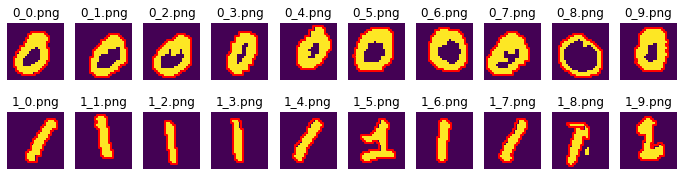

In [9]:
# Apply affine transformations with boolean flags
rotation = False
scaling = False

translation = True

im_af0 = []
im_af1 = []

for img0, img1, nm0, nm1 in zip(zeros_im, ones_im, zeros_names, ones_names):
    img0 = affineTransform (img0, rotation, scaling, translation)
    img1 = affineTransform (img1, rotation, scaling, translation)

    im_af0.append(img0)
    im_af1.append(img1)

# Contour detection
contourf_af0 = contour_fourier(im_af0)
contourf_af1 = contour_fourier(im_af1)

# Plots
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
plotImagContour(axes, contourf_af0, contourf_af1, im_af0, im_af1, zeros_names, ones_names)


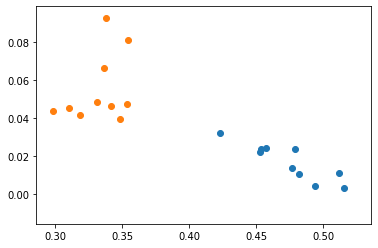

In [10]:
# original images
f1 = 1
f2 = 3
div = 0 # No division when set to -1
# N = 30 # number of pts in fft

FD_0 = np.zeros((10,2))
FD_1 = np.zeros((10,2))

for i in range(10):
    fft0 = np.fft.fft(contourf_0[i])#,n = N)
    fft1 = np.fft.fft(contourf_1[i])#, n = N)
    fft0[-1] = 1
    fft1[-1] = 1 
    
    freq0 = np.fft.fftfreq(len(contourf_af0[i]))
    freq1 = np.fft.fftfreq(len(contourf_af1[i]))

    # normalization
    FD_0[i,:]  = np.abs([fft0[f1],fft0[f2]])/np.abs(fft0[div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
    FD_1[i,:]  = np.abs([fft1[f1],fft1[f2]])/np.abs(fft1[div])
        
   # print(FD_0)
plt.scatter(FD_0[:,0],FD_0[:,1]) 
plt.scatter(FD_1[:,0],FD_1[:,1])

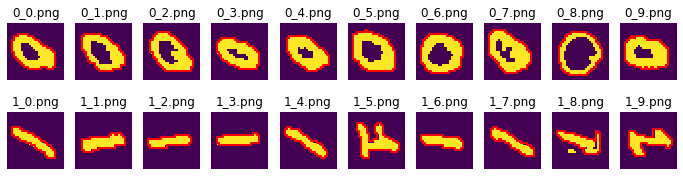

In [11]:
# Apply affine transformations with boolean flags
rotation = True
scaling = False

translation = False

im_af0 = []
im_af1 = []

for img0, img1, nm0, nm1 in zip(zeros_im, ones_im, zeros_names, ones_names):
    img0 = affineTransform (img0, rotation, scaling, translation)
    img1 = affineTransform (img1, rotation, scaling, translation)

    im_af0.append(img0)
    im_af1.append(img1)

# Contour detection
contourf_af0 = contour_fourier(im_af0)
contourf_af1 = contour_fourier(im_af1)

# Plots
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
plotImagContour(axes, contourf_af0, contourf_af1, im_af0, im_af1, zeros_names, ones_names)


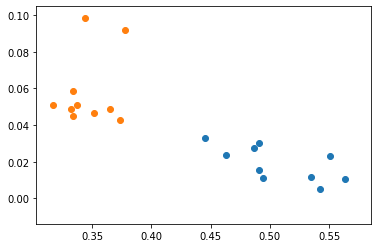

In [12]:
# original images
f1 = 1
f2 = 3
div = 0 # No division when set to -1
# N = 30 # number of pts in fft

FD_0_orig = np.zeros((10,2))
FD_1_orig = np.zeros((10,2))

for i in range(10):
    fft0 = np.fft.fft(contourf_af0[i])#,n = N)
    fft1 = np.fft.fft(contourf_af1[i])#, n = N)
    fft0[-1] = 1
    fft1[-1] = 1 
    
    freq0 = np.fft.fftfreq(len(contourf_0[i]))
    freq1 = np.fft.fftfreq(len(contourf_1[i]))

    # normalization
    FD_0_orig[i,:]  = np.abs([fft0[f1],fft0[f2]])/np.abs(fft0[div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
    FD_1_orig[i,:]  = np.abs([fft1[f1],fft1[f2]])/np.abs(fft1[div])
        
   # print(FD_0)
plt.scatter(FD_0_orig[:,0],FD_0_orig[:,1]) 
plt.scatter(FD_1_orig[:,0],FD_1_orig[:,1])

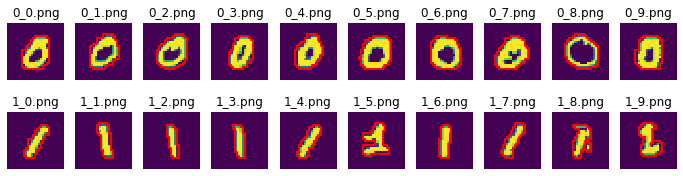

In [13]:
# Apply affine transformations with boolean flags
rotation = False
scaling = True

translation = False

im_af0 = []
im_af1 = []

for img0, img1, nm0, nm1 in zip(zeros_im, ones_im, zeros_names, ones_names):
    img0 = affineTransform (img0, rotation, scaling, translation)
    img1 = affineTransform (img1, rotation, scaling, translation)

    im_af0.append(img0)
    im_af1.append(img1)

# Contour detection
contourf_af0 = contour_fourier(im_af0)
contourf_af1 = contour_fourier(im_af1)

# Plots
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
plotImagContour(axes, contourf_af0, contourf_af1, im_af0, im_af1, zeros_names, ones_names)

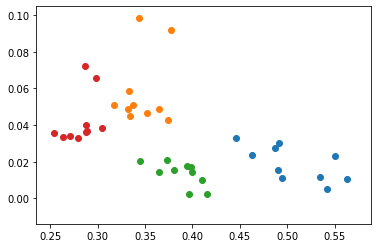

In [14]:
# original images
f1 = 1
f2 = 3
div = 0 # No division when set to -1
# N = 30 # number of pts in fft

FD_0 = np.zeros((10,2))
FD_1 = np.zeros((10,2))

for i in range(10):
    fft0 = np.fft.fft(contourf_af0[i])#,n = N)
    fft1 = np.fft.fft(contourf_af1[i])#, n = N)
    fft0[-1] = 1
    fft1[-1] = 1 
    
    freq0 = np.fft.fftfreq(len(contourf_af0[i]))
    freq1 = np.fft.fftfreq(len(contourf_af1[i]))

    # normalization
    FD_0[i,:]  = np.abs([fft0[f1],fft0[f2]])/np.abs(fft0[div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
    FD_1[i,:]  = np.abs([fft1[f1],fft1[f2]])/np.abs(fft1[div])
        
   # print(FD_0)


# Superimposed plot of original and transformed
plt.scatter(FD_0_orig[:,0],FD_0_orig[:,1]) 
plt.scatter(FD_1_orig[:,0],FD_1_orig[:,1])
plt.scatter(FD_0[:,0],FD_0[:,1]) 
plt.scatter(FD_1[:,0],FD_1[:,1])

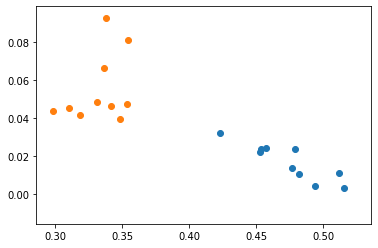

In [15]:
# original images
f1 = 1
f2 = 3
div = 0 # No division when set to -1
# N = 30 # number of pts in fft

FD_0 = np.zeros((10,2))
FD_1 = np.zeros((10,2))

for i in range(10):
    fft0 = np.fft.fft(contourf_0[i])#,n = N)
    fft1 = np.fft.fft(contourf_1[i])#, n = N)
    fft0[-1] = 1
    fft1[-1] = 1 
    
    freq0 = np.fft.fftfreq(len(contourf_0[i]))
    freq1 = np.fft.fftfreq(len(contourf_1[i]))

    # normalization
    FD_0[i,:]  = np.abs([fft0[f1],fft0[f2]])/np.abs(fft0[div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
    FD_1[i,:]  = np.abs([fft1[f1],fft1[f2]])/np.abs(fft1[div])
        
   # print(FD_0)
plt.scatter(FD_0[:,0],FD_0[:,1]) 
plt.scatter(FD_1[:,0],FD_1[:,1])

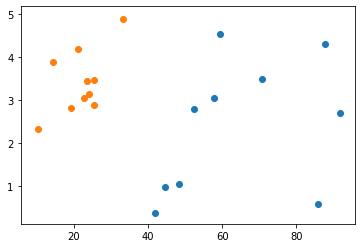

In [16]:
# original images
f1 = 1
f2 = 3
div = 5 # No division when set to -1
# N = 30 # number of pts in fft

FD_0 = np.zeros((10,2))
FD_1 = np.zeros((10,2))

for i in range(10):
    fft0 = np.fft.fft(contourf_0[i])#,n = N)
    fft1 = np.fft.fft(contourf_1[i])#, n = N)

    fft0[-1] = 1
    fft1[-1] = 1 

    freq0 = np.fft.fftfreq(len(contourf_0[i]))
    freq1 = np.fft.fftfreq(len(contourf_1[i]))

    # normalization
    FD_0[i,:]  = np.abs([fft0[f1],fft0[f2]])/np.abs(fft0[div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
    FD_1[i,:]  = np.abs([fft1[f1],fft1[f2]])/np.abs(fft1[div])
        

plt.scatter(FD_0[:,0],FD_0[:,1]) 
plt.scatter(FD_1[:,0],FD_1[:,1])


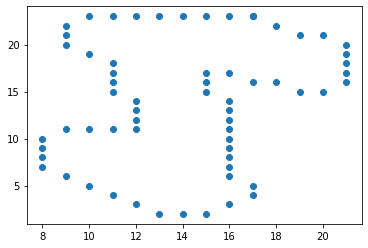

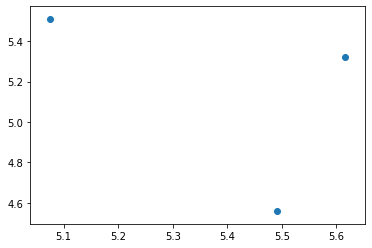

In [17]:
# Test IFFT it appears we need DC component?? Also not perfect reconstruction even if using all fourier coeffs? 
# sampling points??
i = 9
R = np.fft.ifft([fft1[1:]])
signal = contourf_1[i]
xr = np.real(signal)
yr = np.imag(signal)
plt.scatter(xr,yr)
plt.show()
signal = R
xr = np.real(signal)
yr = np.imag(signal)
plt.scatter(xr[xr>5],yr[xr>5])

In [18]:
# Checked the points are in successive order
for i in range(len(contour)):
    plt.scatter(contour[i,1],contour[i,0], marker='x', color='red')
    plt.text(contour[i,1]+.05, contour[i,0]+.05, i, fontsize=9)
plt.show()

NameError: name 'contour' is not defined

### 1.3 Additional method(s)
Add your implementation and discussion

### Skeleton

### PCA -- MS

### Compacity -- CV

### Freeman Code


### Moments -- WJ


Freeman

In [ ]:
import cv2

In [223]:
contours, hierarchy = cv2.findContours(ones_im[0], cv2.RETR_TREE, cv2.CHAIN_CODE )

AttributeError: module 'cv2.cv2' has no attribute 'CHAIN_CODE'

In [ ]:
(contours)

Morphological Skeleton

In [30]:
from scipy.ndimage import morphology

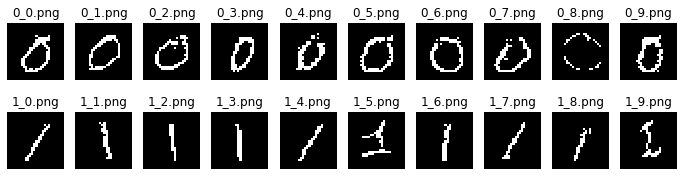

In [361]:
N = 6
Sr_zeros_im = []
Sr_ones_im = []
for im in zeros_im:
    for r in np.arange(3,6):

        se = cv2.getStructuringElement(cv2.MORPH_CROSS,(r,r))

        img = morphology.binary_erosion(im,se,iterations=1).astype(np.int)
        img2 = morphology.binary_opening(img,se,iterations=1).astype(np.int)

        if r==3: 
            Sr_zeros = img - img2
        else:
            Sr_zeros += img - img2
        Sr_zeros[Sr_zeros>0]=1
    Sr_zeros_im.append(Sr_zeros)
for im in ones_im:
    for r in np.arange(3,6):

        se = cv2.getStructuringElement(cv2.MORPH_CROSS,(r,r))

        img = morphology.binary_erosion(im,se,iterations=1).astype(np.int)
        img2 = morphology.binary_opening(img,se,iterations=1).astype(np.int)

        if r==3: 
            Sr_ones = img - img2
        else:
            Sr_ones += img - img2
        Sr_ones[Sr_ones>0]=1
    Sr_ones_im.append(Sr_ones)    
        
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], Sr_zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], Sr_ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

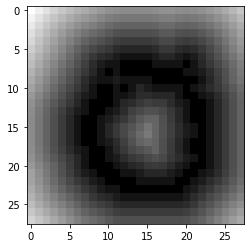

In [437]:
distance_map_0 = morphology.distance_transform_edt(1-Sr_zeros_im[6])
plt.imshow(distance_map_0, cmap ='gray')

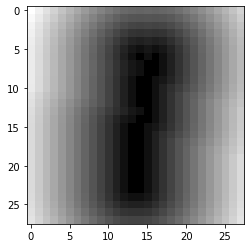

In [438]:
distance_map_1 = morphology.distance_transform_edt(1-Sr_ones_im[6])
plt.imshow(distance_map_1, cmap ='gray')

In [439]:
distance_zeros=[]
for im in Sr_zeros_im:
    distance_0 = np.sum(np.multiply(distance_map_0, im))/np.sum(im)
    distance_1 = np.sum(np.multiply(distance_map_1, im))/np.sum(im)
    distance_zeros.append([distance_0,distance_1])
distance_zeros = np.array(distance_zeros)
print(distance_zeros)

[[1.03573883 2.84814909]
 [0.86959316 3.16200336]
 [0.90461854 3.64535607]
 [1.34445896 2.18486223]
 [1.36848502 2.88164328]
 [0.67873786 3.80795027]
 [0.         4.08910525]
 [1.07819291 4.18233702]
 [1.12000166 4.41019123]
 [0.99035514 2.59266864]]


In [440]:
distance_ones=[]
for im in Sr_ones_im:
    distance_0 = np.sum(np.multiply(distance_map_0, im))/np.sum(im)
    distance_1 = np.sum(np.multiply(distance_map_1, im))/np.sum(im)
    distance_ones.append([distance_0,distance_1])
distance_ones = np.array(distance_ones)
print(distance_ones)

[[2.1659211  1.57794946]
 [2.78977604 1.01806338]
 [2.32138252 0.6472472 ]
 [2.50478072 0.41383252]
 [2.05360038 1.73259961]
 [1.99612433 2.02969724]
 [2.35654856 0.        ]
 [2.03228741 1.43566351]
 [2.25188935 0.76084466]
 [2.05126945 1.59310252]]


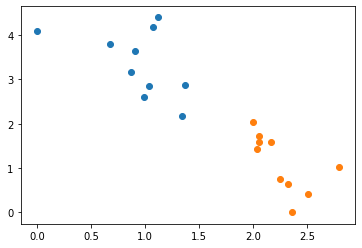

In [441]:
plt.scatter(distance_zeros[:,0],distance_zeros[:,1])
plt.scatter(distance_ones[:,0],distance_ones[:,1])
plt.show()

#### Distance Map method + Contours

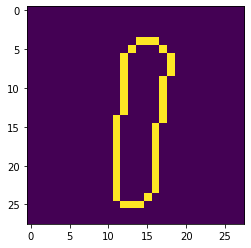

In [315]:
contours = np.array(measure.find_contours(ones_im[6], 0))[0]
cont_1 = np.zeros_like(ones_im[0])
cont_1[contours[:,0].astype(int),contours[:,1].astype(int)]=1
plt.imshow(cont_1)

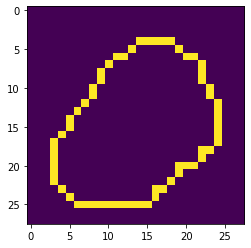

In [316]:
contours = np.array(measure.find_contours(zeros_im[7], 0))[0]
cont_0 = np.zeros_like(zeros_im[0])
cont_0[contours[:,0].astype(int),contours[:,1].astype(int)]=1
plt.imshow(cont_0)

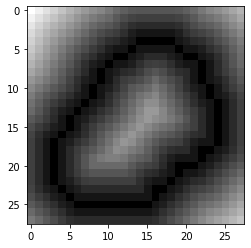

In [317]:
distance_map_0 = morphology.distance_transform_edt(1-cont_0)
plt.imshow(distance_map_0, cmap ='gray')

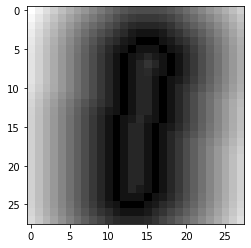

In [318]:
distance_map_1 = morphology.distance_transform_edt(1-cont_1)
plt.imshow(distance_map_1, cmap ='gray')

In [319]:
distance_zeros=[]
for im in zeros_im:
    contours = np.array(measure.find_contours(im, 0))[0]
    cont_0 = np.zeros_like(zeros_im[0])
    cont_0[contours[:,0].astype(int),contours[:,1].astype(int)]=1
    distance_0 = np.sum(np.multiply(distance_map_0, cont_0))
    distance_1 = np.sum(np.multiply(distance_map_1, cont_0))
    distance_zeros.append([distance_0,distance_1])
distance_zeros = np.array(distance_zeros)
print(distance_zeros)

[[ 52.3782036  167.14206195]
 [ 50.89949494 198.18137138]
 [ 53.1869126  214.59002257]
 [ 69.71172365 139.717819  ]
 [ 62.85033956 164.04882314]
 [ 48.14213562 262.21154073]
 [ 71.86295677 250.42663105]
 [  0.         237.74044007]
 [103.64130204 275.4926569 ]
 [ 67.15090264 176.51144141]]


In [320]:
distance_ones=[]
for im in ones_im:
    contours = np.array(measure.find_contours(im, 0))[0]
    cont_1 = np.zeros_like(ones_im[0])
    cont_1[contours[:,0].astype(int),contours[:,1].astype(int)]=1
    distance_0 = np.sum(np.multiply(distance_map_0, cont_1))
    distance_1 = np.sum(np.multiply(distance_map_1, cont_1))
    distance_ones.append([distance_0,distance_1])
distance_ones = np.array(distance_ones)
print(distance_ones)

[[147.31404441  96.06855194]
 [143.1467278   63.60112616]
 [144.39465813  48.48528137]
 [146.71996594  34.95084462]
 [141.69703754  89.76068131]
 [205.24054566 187.08262339]
 [139.38017717   0.        ]
 [150.81300833  87.15265196]
 [168.04586055  73.77654924]
 [185.43886437 111.05739419]]


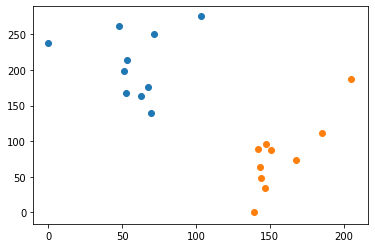

In [321]:
plt.scatter(distance_zeros[:,0],distance_zeros[:,1])
plt.scatter(distance_ones[:,0],distance_ones[:,1])
plt.show()

In [159]:
from skimage.morphology import skeletonize
from skimage.morphology import medial_axis
skeleton = skeletonize(ones_im[4])
skel, distance = medial_axis(zeros_im[5], return_distance=True)
distance[distance<2]=0
dist_on_skel = distance * skel

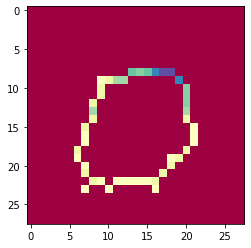

In [160]:
plt.imshow(dist_on_skel, cmap=plt.cm.Spectral, interpolation='nearest')

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

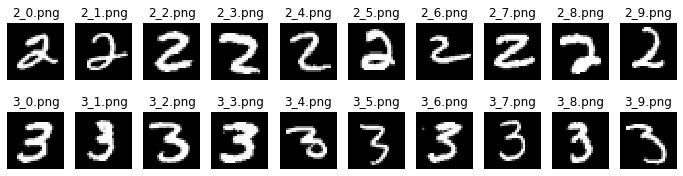

In [19]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

In [ ]:
# Next meeting tentative April 7th!